# 30 minutes traffic prediction

In [481]:
n_steps, n_length = 10, 30
n_input = n_length * n_steps

N = 1440*6
l = 1e-1
dd = 0.05
wd = l**2/n_input
tau = l**2 * (1-dd) / (2 * N * wd)
tau**-1

60.63157894736843

In [473]:
# univariate multi-step encoder-decoder convlstm
import pandas as pd
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D
from keras.layers import Dropout
import numpy as np

# split a univariate dataset into train/test sets
def split_dataset(data):
    # split into standard weeks
    train, test, valid = data[0:-1440*2], data[-1440*2:-1440], data[-1440:]
    # restructure into windows of weekly data
    train = array(split(train, len(train)/30))
    test = array(split(test, len(test)/30))
    valid = array(split(valid, len(valid)/30))
    return train, test, valid

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=30):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end < len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        # move along one time step
        in_start += 1
    return array(X), array(y)

# train the model
def build_model(train, n_steps, n_length, n_input, valid):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    valid_x, valid_y = to_supervised(valid, n_input)
    # define parameters
    verbose, epochs, batch_size = 1, 27, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # reshape into subsequences [samples, time steps, rows, cols, channels]
    train_x = train_x.reshape((train_x.shape[0], n_steps, 1, n_length, n_features))
    valid_x = valid_x.reshape((valid_x.shape[0], n_steps, 1, n_length, n_features))
    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    valid_y = valid_y.reshape((valid_y.shape[0], valid_y.shape[1], 1))
    
    #https://github.com/yaringal/ConcreteDropout/blob/master/spatial-concrete-dropout-keras.ipynb

    
    n_steps, n_length = 10, 30
    n_input = n_length * n_steps

    N = 1440*6
    l = 1e-1
    dd = 0.05
    wd = l**2/n_input
    
    
    from keras.regularizers import l2
    # define model
    model = Sequential()
    model.add(ConvLSTM2D(filters=128, kernel_size=(1,3), 
                         activation='relu', 
                         input_shape=(n_steps, 1, n_length, n_features),
                         W_regularizer=l2(wd),
                         dropout=dd))
    model.add(Flatten())
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(300, activation='relu', return_sequences=True,
                   W_regularizer=l2(wd), 
                   U_regularizer=l2(wd),
                   b_regularizer=l2(wd), 
                   dropout_W=dd, 
                   dropout_U=dd))
    model.add(Dropout(dd))
    model.add(TimeDistributed(Dense(200, activation='relu',
                                    W_regularizer=l2(wd), 
                                    b_regularizer=l2(wd))))
    model.add(Dropout(dd))
    model.add(TimeDistributed(Dense(1, W_regularizer=l2(wd), 
                                    b_regularizer=l2(wd))))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_data=(valid_x, valid_y))
    return model


# make a forecast
def forecast(model, history, n_steps, n_length, n_input):
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, 0]
    # reshape into [samples, time steps, rows, cols, channels]
    input_x = input_x.reshape((1, n_steps, 1, n_length, 1))
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

# evaluate a single model
def evaluate_model(train, test, n_steps, n_length, n_input, model_name, valid):
    # fit model
    model = build_model(train, n_steps, n_length, n_input, valid)
    # serialize model to JSON
    model_json = model.to_json()
    with open("{}.json".format(model_name), "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights("{}.h5".format(model_name))
    print("Saved model to disk")
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast(model, history, n_steps, n_length, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores


In [450]:
dataset = pd.read_csv('https://raw.githubusercontent.com/amasend/SDN_with_Neural_Network/master/smooth_final.csv', index_col=0)

**Compute minute mean**

In [451]:
x1 = pd.date_range(start='2019-1-1 00:00:00', 
                  end='2019-1-1 23:59:59', 
                  freq="1S")
dataset['hour'] = x1.hour
dataset['minute'] = x1.minute

In [452]:
dataset_2 = dataset.groupby(['hour', 'minute']).mean()

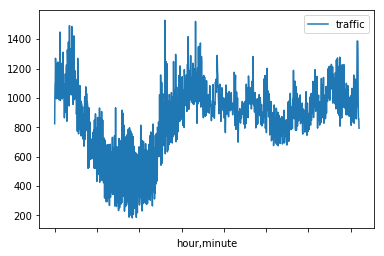

In [453]:
dataset_2.plot()

In [454]:
dataset_2.shape
dataset = dataset_2

**Make 6 days**

In [458]:
# data = pd.Series(standardized.reshape(len(standardized)))
data = dataset['traffic']
for i in range(6):
    data = data.append(dataset['traffic'])
#     data = data.append(pd.Series(standardized.reshape(len(standardized))))
data = data.reset_index(drop=True)

**Add noise**

In [459]:
import numpy as np
for i in range(dataset['traffic'].shape[0], data.shape[0]-10):
#     data[i] = data[i+np.random.randint(-5,5)]
    data[i] += np.random.uniform(low=-50, high=50)

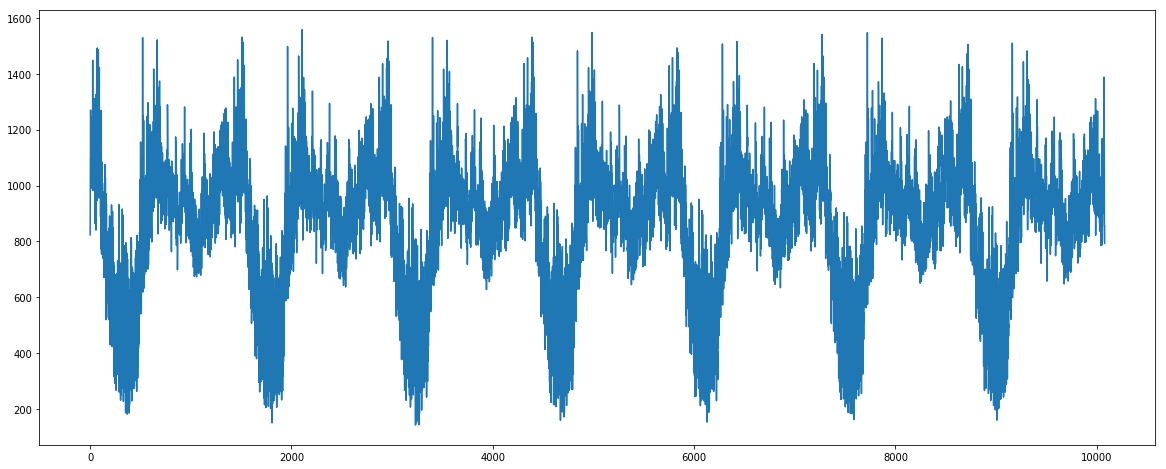

In [460]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.figure(figsize=(20,8))
plt.plot(data.values)

**Standardize**

In [ ]:
from sklearn.preprocessing import StandardScaler
# values = dataset.values
values = np.asarray(data).reshape(len(data), 1)
# train the normalization
scaler = StandardScaler()
scaler = scaler.fit(values)
standardized = scaler.transform(values)

In [ ]:
import pickle

# obj0, obj1, obj2 are created here...

# Saving the objects:
with open('scaler_final_diff_l.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(scaler, f)

# # Getting back the objects:
# with open('objs.pkl') as f:  # Python 3: open(..., 'rb')
#     obj0, obj1, obj2 = pickle.load(f)

In [472]:
# load the new file
# data = dataset['overall']
# split into train and test
train, test, valid = split_dataset(standardized)
train = train.reshape(train.shape[0], train.shape[1], 1)
test = test.reshape(test.shape[0], test.shape[1], 1)
valid = valid.reshape(valid.shape[0], valid.shape[1], 1)
print(train.shape, test.shape, valid.shape)

(240, 30, 1) (48, 30, 1) (48, 30, 1)


In [474]:
model_name = 'model_standardise_with_l_higher_wd_bayasian_RNN'
# define the number of subsequences and the length of subsequences
n_steps, n_length = 10, 30
# define the total days to use as input
n_input = n_length * n_steps
score, scores = evaluate_model(train, test, n_steps, n_length, n_input, model_name, valid)

/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: Update your `ConvLSTM2D` call to the Keras 2 API: `ConvLSTM2D(filters=128, kernel_size=(1, 3), activation="relu", input_shape=(10, 1, 30..., dropout=0.05, kernel_regularizer=<keras.reg...)`
/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:123: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(300, activation="relu", return_sequences=True, kernel_regularizer=<keras.reg..., bias_regularizer=<keras.reg..., recurrent_regularizer=<keras.reg..., dropout=0.05, recurrent_dropout=0.05)`
/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:127: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(200, activation="relu", kernel_regularizer=<keras.reg..., bias_regularizer=<keras.reg...)`
/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:130: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_regularizer=<keras.reg..., bia

Train on 6870 samples, validate on 1110 samples
Epoch 1/27
6870/6870 [==============================] - 154s 22ms/step - loss: 0.4032 - val_loss: 0.3274
Epoch 2/27
6870/6870 [==============================] - 148s 22ms/step - loss: 0.3275 - val_loss: 0.2870
Epoch 3/27
6870/6870 [==============================] - 148s 22ms/step - loss: 0.2982 - val_loss: 0.2641
Epoch 4/27
6870/6870 [==============================] - 156s 23ms/step - loss: 0.2839 - val_loss: 0.2581
Epoch 5/27
6870/6870 [==============================] - 263s 38ms/step - loss: 0.2804 - val_loss: 0.2514
Epoch 6/27
6870/6870 [==============================] - 285s 41ms/step - loss: 0.2722 - val_loss: 0.2551
Epoch 7/27
6870/6870 [==============================] - 286s 42ms/step - loss: 0.2663 - val_loss: 0.2447
Epoch 8/27
6870/6870 [==============================] - 285s 41ms/step - loss: 0.2667 - val_loss: 0.2394
Epoch 9/27
6870/6870 [==============================] - 286s 42ms/step - loss: 0.2608 - val_loss: 0.2353
Epoch 1

In [475]:
# summarize scores
summarize_scores('lstm', score, scores)

lstm: [0.296] 0.3, 0.3, 0.3, 0.2, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.2, 0.3, 0.3, 0.3, 0.4, 0.4, 0.3, 0.3, 0.3, 0.3, 0.4, 0.3, 0.3, 0.3, 0.4, 0.3


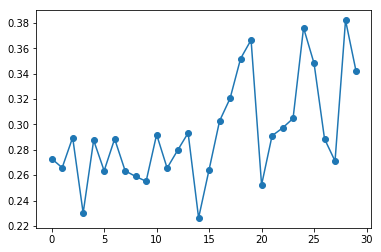

In [476]:
# plot scores
days = range(30)
pyplot.plot(days, scores, marker='o', label='lstm')

In [477]:
# load json and create model
from keras.models import model_from_json
json_file = open('model_standardise_with_l_higher_wd_bayasian_RNN.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("model_standardise_with_l_higher_wd_bayasian_RNN.h5")
print("Loaded model from disk")

# MC_samples = np.array([model.predict(X_val) for _ in range(K_test)])
# history is a list of weekly data
history = [x for x in train]
# walk-forward validation over each week
predictions = list()
for i in range(len(test)):
    # predict the week
    yhat_sequence = forecast(model, history, n_steps, n_length, n_input)
    # store the predictions
    predictions.append(yhat_sequence)
    # get real observation and add to history for predicting the next week
    history.append(test[i, :])
# evaluate predictions days for each week
predictions = array(predictions)
score, scores = evaluate_forecasts(test[:, :, 0], predictions)

Loaded model from disk


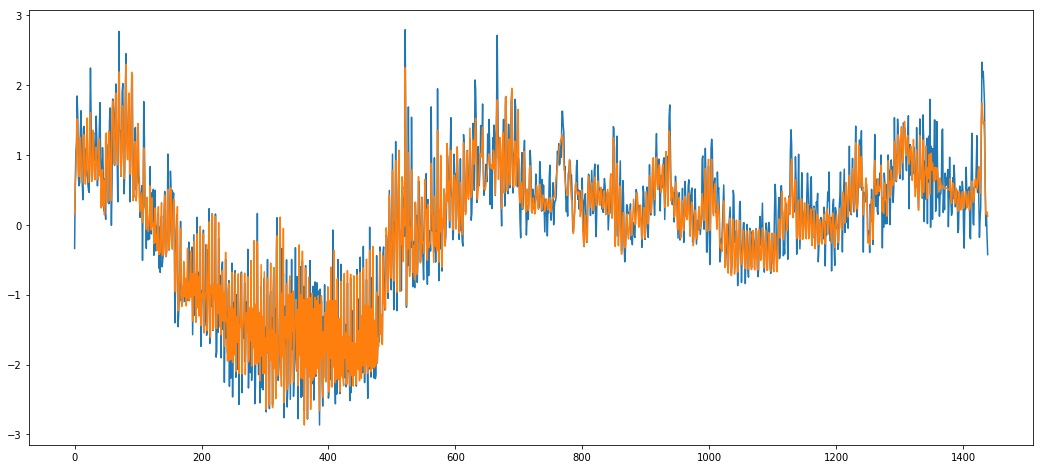

In [478]:
pred = list()
test_ = list()
for i in predictions.reshape(predictions.shape[0]*predictions.shape[1]).tolist():
    pred.append(i)
for i in test.reshape(test.shape[0]*test.shape[1]).tolist():
    test_.append(i)
plt.figure(figsize=(18,8))
plt.plot(test_)
plt.plot(pred)

# predict mean and variance

In [479]:
import keras.backend as K
f = K.function([model.layers[0].input, K.learning_phase()], [model.layers[-1].output])

In [480]:
# make a forecast
def forecast_(model, history, n_steps, n_length, n_input):
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, 0]
    # reshape into [samples, time steps, rows, cols, channels]
    input_x = input_x.reshape((1, n_steps, 1, n_length, 1))
    # forecast the next week
    yhat, uncer, res = predict_with_uncertainty(f,input_x)
    # we only want the vector forecast
#     yhat = yhat[0]
#     uncer = uncer[0]
    return yhat, uncer, res

In [482]:
def predict_with_uncertainty(f, x, n_iter=50):
    result = np.zeros((n_iter,) + (x.shape[3],))
    
    for iter in range(n_iter):
        result[iter] = f([x, 1])[0].reshape(30)

    prediction = result.mean(axis=0)
    uncertainty = result.var(axis=0)

#     uncertainty += tau**-1
    return prediction, uncertainty, result

In [483]:
history = [x for x in train]
# walk-forward validation over each week
predictions = list()
uncertenity = list()
for i in range(len(test)):
    # predict the week
    yhat_sequence, uncert, res = forecast_(model, history, n_steps, n_length, n_input)
    # store the predictions
    predictions.append(yhat_sequence)
    uncertenity.append(uncert)
    # get real observation and add to history for predicting the next week
    history.append(test[i, :])
# evaluate predictions days for each week
predictions = array(predictions)
uncertenity = array(uncertenity)
# score, scores = evaluate_forecasts(test[:, :, 0], predictions)

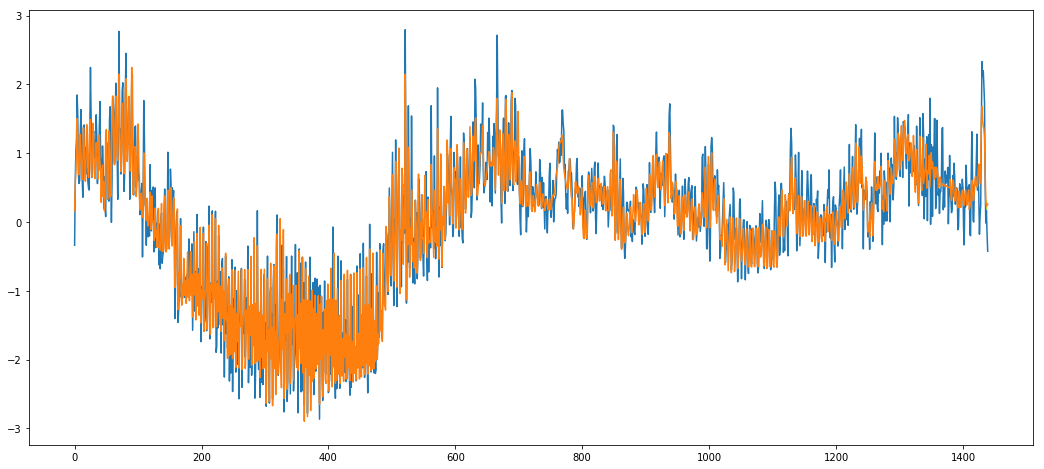

In [484]:
pred = list()
unc = list()
test_ = list()
for i in predictions.reshape(predictions.shape[0]*predictions.shape[1]).tolist():
    pred.append(i)
for i in uncertenity.reshape(uncertenity.shape[0]*uncertenity.shape[1]).tolist():
    unc.append(i)
for i in test.reshape(test.shape[0]*test.shape[1]).tolist():
    test_.append(i)
    
plt.figure(figsize=(18,8))
plt.plot(test_)
plt.plot(pred)
plt.fill_between(range(len(pred)), np.asarray(pred)+np.asarray(unc), np.asarray(pred)-np.asarray(unc), facecolor='yellow')
# plt.plot(unc)

# Anomaly detection based on https://anomaly.io/anomaly-detection-normal-distribution/

# mean +/- 4*sigma

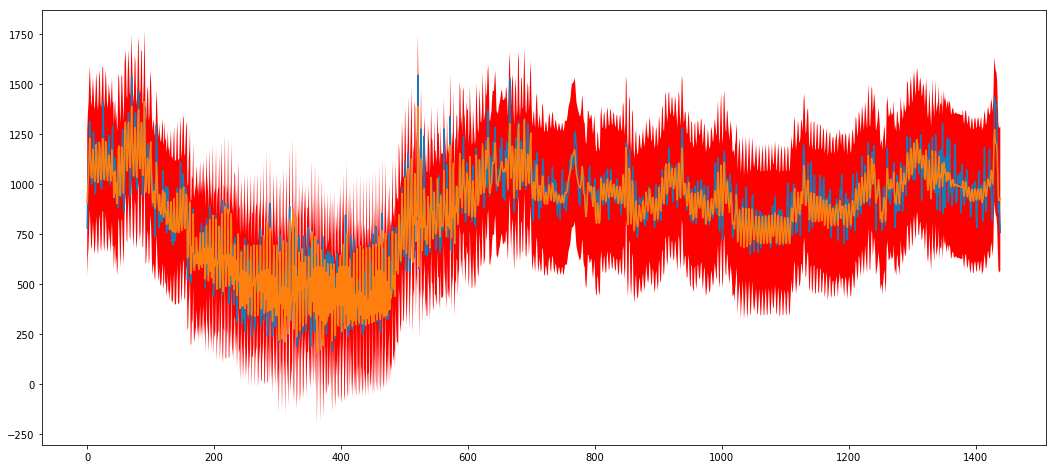

In [509]:
plt.figure(figsize=(18,8))
plt.plot(scaler.inverse_transform(test_))
plt.plot(scaler.inverse_transform(pred))
plt.fill_between(range(len(pred)), 
                 scaler.inverse_transform(np.asarray(pred)) + 
                 (np.sqrt(scaler.inverse_transform(np.asarray(unc))) + tau**-1)*4, 
                 scaler.inverse_transform(np.asarray(pred)) - 
                 (np.sqrt(scaler.inverse_transform(np.asarray(unc))) + tau**-1)*4,
                 facecolor='red')
# plt.xlim([0,30])

# mean +/- 3*sigma

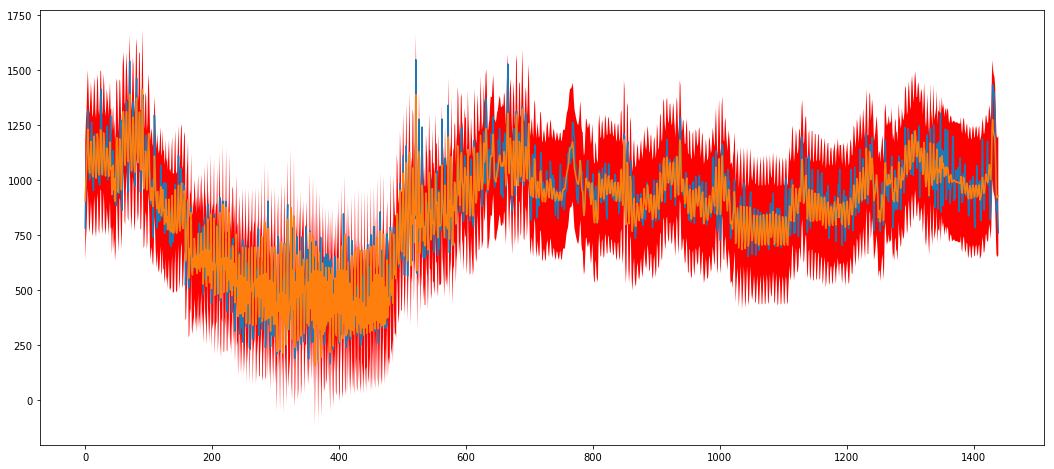

In [511]:
plt.figure(figsize=(18,8))
plt.plot(scaler.inverse_transform(test_))
plt.plot(scaler.inverse_transform(pred))
plt.fill_between(range(len(pred)), 
                 scaler.inverse_transform(np.asarray(pred)) + 
                 (np.sqrt(scaler.inverse_transform(np.asarray(unc))) + tau**-1)*3, 
                 scaler.inverse_transform(np.asarray(pred)) - 
                 (np.sqrt(scaler.inverse_transform(np.asarray(unc))) + tau**-1)*3,
                 facecolor='red')

# mean +/- 2*sigma

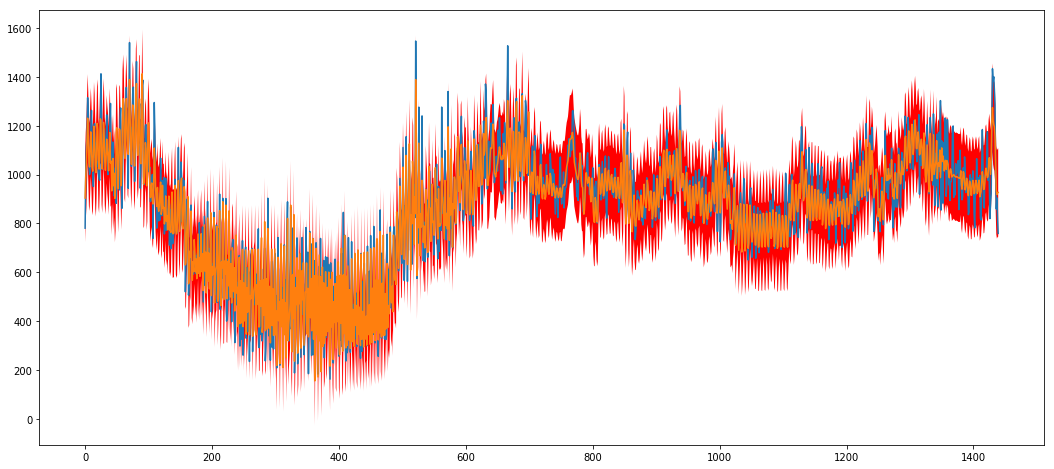

In [512]:
plt.figure(figsize=(18,8))
plt.plot(scaler.inverse_transform(test_))
plt.plot(scaler.inverse_transform(pred))
plt.fill_between(range(len(pred)), 
                 scaler.inverse_transform(np.asarray(pred)) + 
                 (np.sqrt(scaler.inverse_transform(np.asarray(unc))) + tau**-1)*2, 
                 scaler.inverse_transform(np.asarray(pred)) - 
                 (np.sqrt(scaler.inverse_transform(np.asarray(unc))) + tau**-1)*2,
                 facecolor='red')

# mean +/- sigma

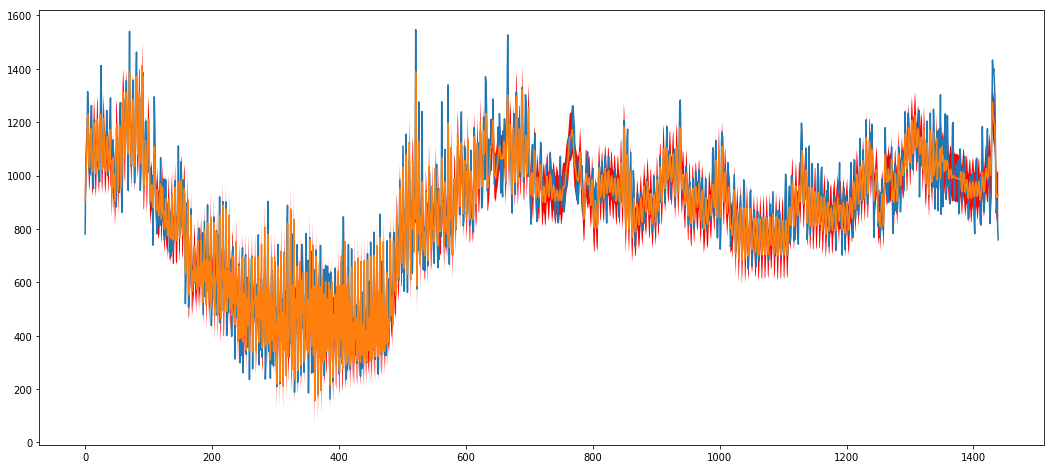

In [513]:
plt.figure(figsize=(18,8))
plt.plot(scaler.inverse_transform(test_))
plt.plot(scaler.inverse_transform(pred))
plt.fill_between(range(len(pred)), 
                 scaler.inverse_transform(np.asarray(pred)) + 
                 (np.sqrt(scaler.inverse_transform(np.asarray(unc))) + tau**-1), 
                 scaler.inverse_transform(np.asarray(pred)) - 
                 (np.sqrt(scaler.inverse_transform(np.asarray(unc))) + tau**-1),
                 facecolor='red')

In [350]:
try:
    print('Trying to import paramiko...')
    import paramiko
    print('Paramiko imported.')
except ImportError:
    print('Paramiko import failed...')
    print('Installing paramiko in conda environment...')
    import sys
    !conda install --yes --prefix {sys.prefix} paramiko

Trying to import paramiko...
Paramiko imported.


In [351]:
try:
    print('Trying to import scp...')
    import scp
    print('Scp imported.')
except ImportError:
    print('Scp import failed...')
    print('Installing scp in conda environment...')
    import sys
    !conda install --yes --prefix {sys.prefix} scp

Trying to import scp...
Scp imported.


In [352]:
def loginanddownload(hostname,uname,pwd,sfile,tfile, put=False):
    """
    Can copy files and directories from PNDa to remote system.
    Usage example:
        loginanddownload(red_pnda_ip, username, password, remote_folder, local_destination)
        loginanddownload('192.168.57.4', 'pnda', 'pnda', '/data', '/home/amadeusz/')
    
    I am using it only for download full copy of /data folder from pnda VM. There is a dependency of openssh-server
    installation on red_pnda VM.
    
    """
    try:
        print("Establishing ssh connection")
        ssh_client = paramiko.SSHClient()
        ssh_client.set_missing_host_key_policy(paramiko.AutoAddPolicy())
        ssh_client.connect(hostname=hostname, username=uname, password=pwd)
    except paramiko.AuthenticationException:
        print("Authentication failed, please verify your credentials: %s")
    except paramiko.SSHException as sshException:
        print("Unable to establish SSH connection: %s" % sshException)
    except paramiko.BadHostKeyException as badHostKeyException:
        print("Unable to verify server's host key: %s" % badHostKeyException)
    except Exception as e:
        print(e.args)
    try:
        print("Getting SCP Client")
        scpclient = scp.SCPClient(ssh_client.get_transport())
        print("Hostname: %s", hostname)
        print("source file: %s", sfile)
        print("target file: %s", tfile)
        if not put:
            scpclient.get(sfile,tfile, recursive = True)
        else:
            scpclient.put(sfile,tfile, recursive = True)
    except scp.SCPException as e:
        print("Operation error: %s", e) 

In [510]:
loginanddownload('pluton.kt.agh.edu.pl', 'amasny', '', '.', 'server_folder', True)

Establishing ssh connection
Getting SCP Client
Hostname: %s pluton.kt.agh.edu.pl
source file: %s .
target file: %s server_folder


In [212]:
loginanddownload('pluton.kt.agh.edu.pl', 'amasny', '', 'model_standardise_with_l_higher_wd_bayasian_RNN.h5', 'model_standardise_with_l_higher_wd_bayasian_RNN.h5', True)

Establishing ssh connection
Getting SCP Client
Hostname: %s pluton.kt.agh.edu.pl
source file: %s model_standardise_32b_bayasian_RNN.h5
target file: %s model_standardise_bayasian_RNN_final.h5
